<a href="https://colab.research.google.com/github/Tarek-1/Recommendation-System-Project-Amazon-Movies/blob/main/Spotify_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Content-Based Music Recommendation with Audio & Lyrics

This notebook implements a robust, content-based music recommendation system that integrates **audio features** and **lyrics embeddings** for nuanced, context-aware suggestions. Leveraging an autoencoder neural network, we learn compact, information-rich representations for each track—enabling accurate recommendations even when lyrics or metadata are missing.

---

## Real-World Data Sourcing:

Our initial goal was to extract **audio features** directly from the Spotify API and lyrics from the Genius API. However, both services impose **strict rate limits and access restrictions**

- **Spotify API:**
    - Has strict rate limits on how many songs you can query per hour or per day.
    - This makes it slow or nearly impossible to gather data for tens of thousands of tracks in a reasonable amount of time.

- **Genius API:**
    - Allows only limited free usage.

So, to work around these limitations, this project uses publicly available datasets and (resources that others have built up over time by collecting data from Spotify and Genius or by having special access) and free APIs. This lets us work with a large and realistic music dataset, without worrying about API restrictions or extra costs.

Because of these same restrictions, it isn’t practical to build a real-time recommendation system using only public APIs—you can’t gather new data for every song quickly or in large quantities. However, if you had paid access to the official APIs, or your own automated system for collecting and processing music data, you could fetch audio features and lyrics for new songs as soon as they’re added, keeping your recommendations fully up to date as your library grows.

- **Audio features:**  
  Sourced from two large Kaggle datasets (totaling ~130,000 unique songs) originally compiled via the Spotify API:
  - [Spotify Audio Features](https://www.kaggle.com/datasets/tomigelo/spotify-audio-features?select=SpotifyAudioFeaturesApril2019.csv)
- **Lyrics:**  
  - Retrieved where possible using the free lyrics.ovh API (limited coverage).
  - Supplemented with a Kaggle dataset derived from the Genius API for broader lyric availability:  
    - [Genius Song Lyrics with Language Information (Kaggle)](https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information/data)

Each song is represented as a unified vector of audio features, a lyrics embedding (or a zero vector if missing), and a `has_lyrics` flag.

---

## Role of Audio Features in the Model

- **Audio features are always included** in the song representation, regardless of lyrics availability.
- In the autoencoder, **both audio and lyrics features (plus the flag) are jointly compressed** into a dense, learned embedding that captures each song’s core musical and lyrical character.
- For tracks with missing lyrics, **recommendations rely solely on the audio features and flag**.

---

## Lyrics Embedding Method

For each song, the lyrics (when available) are embedded into a fixed-size numerical vector using the **`all-MiniLM-L6-v2`** model from the [SentenceTransformers](https://www.sbert.net/) library. This model efficiently captures the semantic meaning of song lyrics and allows for meaningful comparisons between songs based on lyrical content.

- If lyrics are **missing** for a song, we substitute a zero vector of the same length and set a `has_lyrics` flag to indicate the absence of lyrics.
- This approach enables the system to compare songs not only by their musical attributes but also by the deeper meaning in their lyrics—while staying robust for tracks without lyrics.

Each song is ultimately represented as a unified vector of audio features, a MiniLM lyrics embedding (or a zero vector if missing), and the `has_lyrics` flag.

---

## Notebook Workflow

1. **Data Collection:**  
   We start by assembling audio features for a large catalog of songs, supplemented with lyrics whenever available from various sources.

2. **Feature Construction:**  
   Each song is represented by its audio features, a numerical embedding for lyrics (or a zero vector if lyrics are missing), and a binary flag indicating the presence of lyrics.
3. **Model Training:**  
   An autoencoder neural network is trained to compress these rich feature vectors into lower-dimensional embeddings that preserve the most relevant musical and lyrical characteristics.

4. **Generating Recommendations:**  
   For any given song, we use cosine similarity between these learned embeddings to identify and recommend other tracks that are musically and contextually similar, even if some songs lack lyrics.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from tqdm import tqdm
import time
import os
import numpy as np
import requests

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sentence_transformers import SentenceTransformer

# Reading Datasets

In [ ]:
import pandas as pd
spotify_april_2019 = pd.read_csv(f"/content/drive/MyDrive/SpotifyAudioFeaturesApril2019.csv")
spotify_nov_2018 = pd.read_csv(f"/content/drive/MyDrive/SpotifyAudioFeaturesNov2018.csv")

print("April 2019 shape:", spotify_april_2019.shape)
print("Nov 2018 shape:", spotify_nov_2018.shape)

April 2019 shape: (130663, 17)
Nov 2018 shape: (116372, 17)


In [ ]:
common_cols = set(spotify_april_2019.columns) & set(spotify_nov_2018.columns)
len(common_cols)

17

# Merging the two Spotify API Audio Feature Datasets

In [ ]:
df_big = pd.concat([spotify_april_2019, spotify_nov_2018], ignore_index=True)

In [ ]:
df_big.head()

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,0


In [ ]:
df_big.shape

(247035, 17)

# Checking for duplicates

I looked for duplicates based only on the `track_id` column. This allowed me to identify tracks that appear multiple times even if other columns slightly differ.

As an example, the track ID `'2kF08PgGgb3B08QNqsLcov1'` appears four times. All instances have the same values for all features except for minor differences in the `popularity` column.

Next, I’ll decide on a strategy for handling duplicate track_id entries. Most likely, I’ll keep only one row per track_id specifically the most recent one. Alternatively, I could retain the most popular entry for each track, a better way is updating the popularity by fetching fresh data from the Spotify API, but that could be time-consuming due to API rate limits.

In [ ]:
df_big.duplicated(subset='track_id').sum()

np.int64(116046)

In [ ]:
df_big[df_big.duplicated(subset='track_id')].head()

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
1151,I DO,2kFO8PgGgB308QNqsLcov1,Woke Up In Kingston,0.119000,0.690,175136,0.694,0.000000,4,0.0750,-4.288,0,0.3180,131.666,5,0.318,38
1574,Courtney Barnett,4U8JFGd4EZ6w42A6CU1fDj,Crippling Self Doubt And A General Lack Of Sel...,0.000031,0.552,168360,0.726,0.000003,9,0.0642,-5.056,1,0.0270,127.084,3,0.735,41
1936,Nick Grant,4uefRUWMKRD1utYD97uYyN,Black Woman (feat. Stacy Barthe),0.750000,0.483,256153,0.750,0.000000,1,0.1440,-6.492,1,0.4390,79.792,4,0.340,32
2683,Jazz Cartier,6HKmRDdB3jMYRrd8TfFsKM,GODFLOWER,0.026900,0.646,180227,0.823,0.000025,10,0.1110,-4.845,0,0.0445,74.993,4,0.325,42
3344,Kygo,0zhBS3T33cnJUwfoOEmlCL,Kids in Love - The Him Remix,0.104000,0.532,195920,0.723,0.000009,0,0.1140,-4.691,1,0.0449,125.071,4,0.181,48


In [ ]:
df_big[df_big['track_id'] == '2kFO8PgGgB308QNqsLcov1']

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
463,I Do,2kFO8PgGgB308QNqsLcov1,Woke Up In Kingston,0.119,0.69,175136,0.694,0.0,4,0.075,-4.288,0,0.318,131.666,5,0.318,38
1151,I DO,2kFO8PgGgB308QNqsLcov1,Woke Up In Kingston,0.119,0.69,175136,0.694,0.0,4,0.075,-4.288,0,0.318,131.666,5,0.318,38
131137,I Do,2kFO8PgGgB308QNqsLcov1,Woke Up In Kingston,0.119,0.69,175136,0.694,0.0,4,0.075,-4.288,0,0.318,131.666,5,0.318,37
131858,I DO,2kFO8PgGgB308QNqsLcov1,Woke Up In Kingston,0.119,0.69,175136,0.694,0.0,4,0.075,-4.288,0,0.318,131.666,5,0.318,37


In [ ]:
df_big_deduped = df_big.sort_values('popularity', ascending=False).drop_duplicates(subset='track_id').reset_index(drop=True)
df_big_deduped.duplicated(subset='track_id').sum()

np.int64(0)

I decided to retain a single row per track_id by keeping the entry with the highest popularity

# Checking null values

In [ ]:
df_big_deduped.isnull().sum()

,0
artist_name,0
track_id,0
track_name,1
acousticness,0
danceability,0
duration_ms,0
energy,0
instrumentalness,0
key,0
liveness,0


Only 1 record is null so we can drop it

In [ ]:
df_big_deduped = df_big_deduped.dropna(subset=['track_name']).reset_index(drop=True)
df_big_deduped.isnull().sum()

,0
artist_name,0
track_id,0
track_name,0
acousticness,0
danceability,0
duration_ms,0
energy,0
instrumentalness,0
key,0
liveness,0



# Get Lyrics Using lyrics.ovh API
> I used the free lyrics.ovh API to collect song lyrics, running this script continuously over several days. Although the API is quite slow and some songs are missing lyrics, I was able to gather lyrics for around 20,000 tracks—significantly expanding the dataset.  
>  
> Using paid APIs like Genius would offer more complete results, but since they require commercial access, lyrics.ovh was a practical choice for this project.



In [ ]:
output_path = "/content/drive/MyDrive/SONG_SPOTY.csv"

# If file exists, load it to skip already done songs
if os.path.exists(output_path):
    done_df = pd.read_csv(output_path)
    done_set = set(zip(done_df["artist"], done_df["track"]))
else:
    done_df = pd.DataFrame(columns=["artist", "track", "lyrics"])
    done_set = set()

# Function to get lyrics
def get_lyrics(artist, title):
    url = f"https://api.lyrics.ovh/v1/{artist}/{title}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.json().get("lyrics", "Lyrics not found.")
        else:
            return f"Error {response.status_code}"
    except Exception as e:
        return str(e)

# Fetch and append
for i, row in df_big_deduped.iterrows():
    artist = row["artist_name"]
    track = row["track_name"]
    key = (artist, track)

    if key in done_set:
        continue  # Skip already processed

    lyrics = get_lyrics(artist, track)
    new_row = pd.DataFrame([{"artist": artist, "track": track, "lyrics": lyrics}])
    done_df = pd.concat([done_df, new_row], ignore_index=True)

    # Save progress after each song
    done_df.to_csv(output_path, index=False)
    print(f"[{i+1}] Saved: {artist} - {track}")
    time.sleep(1)

# Lyrics results from lyrics.ovh API
> After several days of running and saving results from this api, i was able to obtain 20k song lyrics.

In [ ]:
lyrics_df = pd.read_csv("/content/drive/MyDrive/SONG_SPOTY.csv")

In [ ]:
lyrics_df[(lyrics_df['lyrics'].isnull()) | (lyrics_df['lyrics'] == 'Error 404')]

,artist,track,lyrics
3,post malone,sunflower - spider-man: into the spider-verse,NaN
9,lady gaga,shallow,NaN
11,marshmello,happier,NaN
20,post malone,sunflower - spider-man: into the spider-verse,NaN
28,xxxtentacion,arms around you (feat. maluma & swae lee),NaN
...,...,...,...
130605,Silk City,Electricity (with Dua Lipa),Error 404
130613,Sofia Reyes,R.I.P. (feat. Rita Ora & Anitta),Error 404
130617,Wisin & Yandel,Aullando,Error 404
130620,Luis Fonsi,Imposible,Error 404


In [ ]:
lyrics_df['lyrics'] = lyrics_df['lyrics'].replace("Error 404", np.nan)

# Completing Lyrics Coverage with Genius Kaggle Data

To fill in the missing lyrics that couldn’t be retrieved via the API, we use a public Kaggle dataset of song lyrics sourced from Genius.  
This step expands our dataset by providing lyrics for thousands of additional tracks, making the final dataset much more complete and valuable for music recommendation tasks.


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d carlosgdcj/genius-song-lyrics-with-language-information

Dataset URL: https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information
License(s): unknown
 98% 2.98G/3.04G [00:54<00:03, 16.5MB/s]
100% 3.04G/3.04G [00:54<00:00, 59.8MB/s]


In [ ]:
!unzip genius-song-lyrics-with-language-information.zip

Archive:  genius-song-lyrics-with-language-information.zip
  inflating: song_lyrics.csv         


In [ ]:
# get only rows where lyrics are missing
missing = lyrics_df[lyrics_df['lyrics'].isna()][['artist', 'track']].drop_duplicates()
missing['artist'] = missing['artist'].str.lower().str.strip()
missing['track'] = missing['track'].str.lower().str.strip()

matched_rows = []

# Read the lyrics file in chunks and match only missing ones
for chunk in pd.read_csv("/content/song_lyrics.csv", chunksize=100_000, encoding='utf-8', low_memory=False):
    chunk['artist'] = chunk['artist'].str.lower().str.strip()
    chunk['title'] = chunk['title'].str.lower().str.strip()

    # Match artist + track (Spotify) with artist + title (Genius)
    matched = missing.merge(chunk, left_on=['artist', 'track'], right_on=['artist', 'title'])

    if not matched.empty:
        matched_rows.append(matched[['artist', 'track', 'lyrics']])

# Combine all matched results
recovered_lyrics_df = pd.concat(matched_rows, ignore_index=True)

print("Recovered rows: ", len(recovered_lyrics_df))
print(recovered_lyrics_df.head())

In [ ]:
# Normalize keys just to be safe before merging
lyrics_df['artist'] = lyrics_df['artist'].str.lower().str.strip()
lyrics_df['track'] = lyrics_df['track'].str.lower().str.strip()
recovered_lyrics_df['artist'] = recovered_lyrics_df['artist'].str.lower().str.strip()
recovered_lyrics_df['track'] = recovered_lyrics_df['track'].str.lower().str.strip()


lyrics_df = lyrics_df.merge(
    recovered_lyrics_df[['artist', 'track', 'lyrics']],
    on=['artist', 'track'],
    how='right',
    suffixes=('', '_new')
)

# Fill only the missing lyrics
lyrics_df['lyrics'] = lyrics_df['lyrics'].combine_first(lyrics_df['lyrics_new'])

lyrics_df = lyrics_df.drop(columns=['lyrics_new'])

In [ ]:
lyrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130500 entries, 0 to 130499
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   artist  130500 non-null  object
 1   track   130500 non-null  object
 2   lyrics  39890 non-null   object
dtypes: object(3)
memory usage: 3.0+ MB


In [ ]:
lyrics_df.to_csv("/content/drive/MyDrive/SONG_SPOTY.csv", index=False)

# Results:Lyrics (Genius) +  Audio Features Spotify

In [ ]:
lyrics_df = pd.read_csv("/content/drive/MyDrive/SONG_SPOTY.csv")
non_null_lyrics_df = lyrics_df[lyrics_df['lyrics'].notna()]
non_null_lyrics_df

,artist,track,lyrics
0,ariana grande,"thank u, next",Thought I'd end up with Sean\r\nBut he wasn't ...
1,daddy yankee,con calma,"[Letra de ""Con Calma"" ft. Snow]\n\n[Intro: Dad..."
2,dj snake,"taki taki (with selena gomez, ozuna & cardi b)","Wo-oh, oh-oh\r\nBailame como si fuera la últim..."
4,jonas brothers,sucker,We go together\r\nBetter than birds of a feath...
5,billie eilish,bad guy,"White shirt, now red my bloody nose\r\nSleepin..."
...,...,...,...
130638,Reik,Amigos Con Derechos,Te presto mis ojos para que veas lo hermosa qu...
130639,Maluma,Mala Mía,"Me besé a tu novia, mala mía\r\nMe pasé de tra..."
130640,George Ezra,Shotgun,"Home grown alligator, see you later\r\nGotta h..."
130641,Karol G,Créeme,Yay\r\nYa (hahaha)\r\nDice\r\n¿Cómo explicarle...


# Checking duplicates again

Before i droped duplicated track_id only, now i noticed some artist_name + track_name are duplicated too but with a different track_id so lets drop those.

In [ ]:
non_null_lyrics_df.duplicated(subset=['artist', 'track']).sum()

np.int64(216)

In [ ]:
non_null_lyrics_df[non_null_lyrics_df.duplicated(subset=['artist', 'track'], keep=False)]

,artist,track,lyrics
24,kodak black,zeze (feat. travis scott & offset),"D.A. got that dope!\r\nIce water, turned Atlan..."
43,juice wrld,lucid dreams,I still see your shadows in my room\r\nCan't t...
62,kodak black,zeze (feat. travis scott & offset),"D.A. got that dope!\r\nIce water, turned Atlan..."
64,juice wrld,lucid dreams,I still see your shadows in my room\r\nCan't t...
92,ariana grande,no tears left to cry,"Right now, I'm in a state of mind\r\nI wanna b..."
...,...,...,...
130520,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,Error 404
130524,Kodak Black,ZEZE (feat. Travis Scott & Offset),"D.A. got that dope!\r\nIce water, turned Atlan..."
130543,Juice WRLD,Lucid Dreams,I still see your shadows in my room\r\nCan't t...
130562,Kodak Black,ZEZE (feat. Travis Scott & Offset),"D.A. got that dope!\r\nIce water, turned Atlan..."


In [ ]:
df_big_deduped.duplicated(subset=['artist_name', 'track_name']).sum()

np.int64(659)

In [ ]:
df_big_deduped[df_big_deduped.duplicated(subset=['artist_name', 'track_name'], keep=False)].sort_values(by=['artist_name', 'track_name'])

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
1627,$uicideBoy$,7wPHEEGn0rWMZEDrDcOaDa,Carrollton,0.00221,0.844,203897,0.520,0.001220,5,0.7000,-10.626,0,0.5330,149.995,4,0.2890,72
5960,$uicideBoy$,1T3cZ3XAnIjc9M91bhshcu,Carrollton,0.00221,0.844,203897,0.520,0.001220,5,0.7000,-10.626,0,0.5330,149.995,4,0.2890,62
10529,2 Chainz,728wpR0sdHsE8rrAngOKMS,Hot Wings,0.15700,0.902,195587,0.646,0.000010,9,0.0880,-5.218,1,0.3450,139.989,4,0.4160,57
47247,2 Chainz,32kLgX1r4lnxsG7ZboCW1C,Hot Wings,0.13500,0.900,195333,0.635,0.000015,2,0.0846,-5.203,1,0.3170,139.993,4,0.3700,32
1471,5 Seconds of Summer,2vHfabj6nFebekTYODqntl,Want You Back,0.00699,0.618,173082,0.867,0.000001,0,0.2020,-4.915,1,0.0439,98.030,4,0.5790,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875,isaac gracie,3kf5CAa39M9pmbXlnSCtpT,reverie,0.84200,0.218,343249,0.243,0.768000,8,0.1090,-11.173,1,0.0299,155.306,3,0.0708,56
12421,itssvd,1EKRYZiL7fFzza6QppJIbY,Safe,0.83700,0.608,78215,0.460,0.001080,11,0.1070,-13.083,0,0.1490,114.886,4,0.5110,55
114844,itssvd,0gak9U5eiw0OtPVWJCNALH,Safe,0.83700,0.608,78215,0.460,0.001080,11,0.1070,-13.083,0,0.1490,114.886,4,0.5110,2
13640,slenderbodies,7bWTJ9aXMNGoQ3rCQEjEWu,take you home,0.16500,0.775,230185,0.541,0.000049,5,0.0929,-5.892,0,0.0498,97.993,4,0.8170,54


In [ ]:
df_big_deduped = df_big_deduped.drop_duplicates(subset=['artist_name', 'track_name'], keep=False)
non_null_lyrics_df = non_null_lyrics_df.drop_duplicates(subset=['artist', 'track'], keep=False)

## Now I have 130k tracks with audio features from Spotify, and 40k Lyrics from lyrics.ovh and Genius.

# Embedding lyrics

In [ ]:
# Load the pretrained model
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Exception ignored in: <function _xla_gc_callback at 0x7e3994826340>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
tqdm.pandas()
non_null_lyrics_df['lyrics_embedding'] = non_null_lyrics_df['lyrics'].progress_apply(lambda x: model.encode(x, show_progress_bar=False))

In [ ]:
non_null_lyrics_df.to_pickle('/content/drive/MyDrive/non_null_lyrics_with_embeddings.pkl')

# Preparing Features for the Autoencoder

This section brings together all the features needed for modeling:

- **Load data:** After embedding and storing the results, we read it.
- **Merge datasets:** Lyrics embeddings are matched and merged with the audio features using artist and track info.
- **Handle missing lyrics:** Songs without lyrics get a zero-vector embedding, plus a `has_lyrics` flag.
- **Normalize & combine:** Audio features are standardized, then concatenated with the lyrics embeddings to form the final input matrix.

The resulting dataset ensures every song—regardless of lyrics availability is represented by a single, unified feature vector ready for training the autoencoder.


In [ ]:
non_null_lyrics_df = pd.read_pickle('/content/drive/MyDrive/non_null_lyrics_with_embeddings.pkl')

non_null_lyrics_df.head()

,artist,track,lyrics,lyrics_embedding
0,ariana grande,"thank u, next",Thought I'd end up with Sean\r\nBut he wasn't ...,"[-0.08258274, -0.102095895, 0.1020967, -0.0223..."
1,daddy yankee,con calma,"[Letra de ""Con Calma"" ft. Snow]\n\n[Intro: Dad...","[-0.059745092, -0.05878536, 0.045668133, -0.02..."
2,dj snake,"taki taki (with selena gomez, ozuna & cardi b)","Wo-oh, oh-oh\r\nBailame como si fuera la últim...","[-0.026024615, 0.03299887, 0.10863314, -0.0151..."
4,jonas brothers,sucker,We go together\r\nBetter than birds of a feath...,"[-0.058656648, -0.018098967, 0.04686344, 0.003..."
5,billie eilish,bad guy,"White shirt, now red my bloody nose\r\nSleepin...","[-0.042907674, -0.05108223, 0.027952714, 0.022..."


In [ ]:
# convert the embeddings column to a 2D numpy array
embeddings = np.stack(non_null_lyrics_df['lyrics_embedding'].values)
embeddings.shape

(39631, 384)

In [ ]:
df_big_deduped

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,Ariana Grande,2rPE9A1vEgShuZxxzR2tZH,"thank u, next",0.28000,0.724,207333,0.647,0.000000,1,0.1020,-5.642,1,0.0658,106.960,4,0.435,100
1,Daddy Yankee,5w9c2J52mkdntKOmRLeM2m,Con Calma,0.11000,0.737,193227,0.860,0.000002,8,0.0574,-2.652,0,0.0593,93.989,4,0.656,100
2,DJ Snake,4w8niZpiMy6qz1mntFA5uM,"Taki Taki (with Selena Gomez, Ozuna & Cardi B)",0.15300,0.841,212500,0.798,0.000003,1,0.0618,-4.206,0,0.2290,95.948,4,0.591,99
4,Jonas Brothers,4y3OI86AEP6PQoDE6olYhO,Sucker,0.04270,0.842,181040,0.734,0.000000,1,0.1060,-5.065,0,0.0588,137.958,4,0.952,98
5,Billie Eilish,2Fxmhks0bxGSBdJ92vM42m,bad guy,0.30800,0.708,194088,0.418,0.093000,0,0.1000,-10.998,1,0.3680,131.926,4,0.578,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130983,Traditional,1VRHA7HONPS69sbda4OdAv,御使いうたいて(グリーンスリーブス),0.97900,0.184,180634,0.234,0.882000,7,0.1540,-11.705,0,0.0405,125.619,4,0.118,0
130984,Traditional,1rPByevm4Lg412UVmg2X9J,天には栄え,0.62700,0.176,78170,0.327,0.851000,0,0.1570,-8.231,1,0.0335,81.318,1,0.161,0
130985,Traditional,2KRM4cByCU7SxsYF8ENfes,牧人羊を,0.84900,0.184,135000,0.294,0.914000,0,0.1990,-8.911,1,0.0405,133.216,1,0.196,0
130986,Ludwig van Beethoven,1QAQfwZisoKRYQjF7muPtG,"11 Bagatelles, Op. 119: No. 10 in A Major",0.99000,0.464,15510,0.236,0.943000,3,0.1250,-25.760,1,0.0452,111.415,4,0.000,0


In [ ]:
df_merged = df_big_deduped.merge(
    non_null_lyrics_df[['artist', 'track', 'lyrics_embedding']],
    left_on=['artist_name', 'track_name'],
    right_on=['artist', 'track'],
    how='left'
).drop(columns=['artist', 'track'])

In [ ]:
df_merged.head()

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,lyrics_embedding
0,Ariana Grande,2rPE9A1vEgShuZxxzR2tZH,"thank u, next",0.2800,0.724,207333,0.647,0.000000,1,0.1020,-5.642,1,0.0658,106.960,4,0.435,100,"[-0.08258274, -0.102095895, 0.1020967, -0.0223..."
1,Daddy Yankee,5w9c2J52mkdntKOmRLeM2m,Con Calma,0.1100,0.737,193227,0.860,0.000002,8,0.0574,-2.652,0,0.0593,93.989,4,0.656,100,"[-0.007473608, 0.015736792, -0.025242494, -0.0..."
2,DJ Snake,4w8niZpiMy6qz1mntFA5uM,"Taki Taki (with Selena Gomez, Ozuna & Cardi B)",0.1530,0.841,212500,0.798,0.000003,1,0.0618,-4.206,0,0.2290,95.948,4,0.591,99,"[-0.026024615, 0.03299887, 0.10863314, -0.0151..."
3,Jonas Brothers,4y3OI86AEP6PQoDE6olYhO,Sucker,0.0427,0.842,181040,0.734,0.000000,1,0.1060,-5.065,0,0.0588,137.958,4,0.952,98,"[-0.058656648, -0.018098967, 0.04686344, 0.003..."
4,Billie Eilish,2Fxmhks0bxGSBdJ92vM42m,bad guy,0.3080,0.708,194088,0.418,0.093000,0,0.1000,-10.998,1,0.3680,131.926,4,0.578,98,"[-0.042907674, -0.05108223, 0.027952714, 0.022..."


In [ ]:
embedding_dim = len(df_merged['lyrics_embedding'].dropna().iloc[0])

def fill_missing(x):
    if isinstance(x, (list, np.ndarray)):
        return np.array(x)
    else:
        return np.zeros(embedding_dim)

df_merged['lyrics_embedding'] = df_merged['lyrics_embedding'].apply(fill_missing)
df_merged['has_lyrics'] = df_merged['lyrics_embedding'].apply(lambda x: int(not np.all(x == 0)))

In [ ]:
df_merged

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,lyrics_embedding,has_lyrics
0,Ariana Grande,2rPE9A1vEgShuZxxzR2tZH,"thank u, next",0.28000,0.724,207333,0.647,0.000000,1,0.1020,-5.642,1,0.0658,106.960,4,0.435,100,"[-0.08258274, -0.102095895, 0.1020967, -0.0223...",1
1,Daddy Yankee,5w9c2J52mkdntKOmRLeM2m,Con Calma,0.11000,0.737,193227,0.860,0.000002,8,0.0574,-2.652,0,0.0593,93.989,4,0.656,100,"[-0.007473608, 0.015736792, -0.025242494, -0.0...",1
2,DJ Snake,4w8niZpiMy6qz1mntFA5uM,"Taki Taki (with Selena Gomez, Ozuna & Cardi B)",0.15300,0.841,212500,0.798,0.000003,1,0.0618,-4.206,0,0.2290,95.948,4,0.591,99,"[-0.026024615, 0.03299887, 0.10863314, -0.0151...",1
3,Jonas Brothers,4y3OI86AEP6PQoDE6olYhO,Sucker,0.04270,0.842,181040,0.734,0.000000,1,0.1060,-5.065,0,0.0588,137.958,4,0.952,98,"[-0.058656648, -0.018098967, 0.04686344, 0.003...",1
4,Billie Eilish,2Fxmhks0bxGSBdJ92vM42m,bad guy,0.30800,0.708,194088,0.418,0.093000,0,0.1000,-10.998,1,0.3680,131.926,4,0.578,98,"[-0.042907674, -0.05108223, 0.027952714, 0.022...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129665,Traditional,1VRHA7HONPS69sbda4OdAv,御使いうたいて(グリーンスリーブス),0.97900,0.184,180634,0.234,0.882000,7,0.1540,-11.705,0,0.0405,125.619,4,0.118,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
129666,Traditional,1rPByevm4Lg412UVmg2X9J,天には栄え,0.62700,0.176,78170,0.327,0.851000,0,0.1570,-8.231,1,0.0335,81.318,1,0.161,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
129667,Traditional,2KRM4cByCU7SxsYF8ENfes,牧人羊を,0.84900,0.184,135000,0.294,0.914000,0,0.1990,-8.911,1,0.0405,133.216,1,0.196,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
129668,Ludwig van Beethoven,1QAQfwZisoKRYQjF7muPtG,"11 Bagatelles, Op. 119: No. 10 in A Major",0.99000,0.464,15510,0.236,0.943000,3,0.1250,-25.760,1,0.0452,111.415,4,0.000,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [ ]:
audio_feature_cols = [
    'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
    'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
    'time_signature', 'valence', 'popularity'
]

scaler = StandardScaler()
df_merged[audio_feature_cols] = scaler.fit_transform(df_merged[audio_feature_cols])

In [ ]:
df_merged

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,lyrics_embedding,has_lyrics
0,Ariana Grande,2rPE9A1vEgShuZxxzR2tZH,"thank u, next",-0.181496,0.751020,-0.042660,0.299387,-0.623377,-1.174481,-0.553859,0.663529,0.803194,-0.371169,-0.414555,0.235738,-0.017823,3.845903,"[-0.08258274, -0.102095895, 0.1020967, -0.0223...",1
1,Daddy Yankee,5w9c2J52mkdntKOmRLeM2m,Con Calma,-0.673176,0.819389,-0.156932,1.117235,-0.623372,0.768329,-0.819574,1.120066,-1.245030,-0.423418,-0.844461,0.235738,0.834676,3.845903,"[-0.007473608, 0.015736792, -0.025242494, -0.0...",1
2,DJ Snake,4w8niZpiMy6qz1mntFA5uM,"Taki Taki (with Selena Gomez, Ozuna & Cardi B)",-0.548810,1.366341,-0.000802,0.879176,-0.623368,-1.174481,-0.793360,0.882789,-1.245030,0.940673,-0.779532,0.235738,0.583941,3.793667,"[-0.026024615, 0.03299887, 0.10863314, -0.0151...",1
3,Jonas Brothers,4y3OI86AEP6PQoDE6olYhO,Sucker,-0.867824,1.371600,-0.255658,0.633438,-0.623377,-1.174481,-0.530028,0.751630,-1.245030,-0.427437,0.612831,0.235738,1.976485,3.741432,"[-0.058656648, -0.018098967, 0.04686344, 0.003...",1
4,Billie Eilish,2Fxmhks0bxGSBdJ92vM42m,bad guy,-0.100513,0.666874,-0.149957,-0.579896,-0.365579,-1.452025,-0.565774,-0.154269,0.803194,2.057990,0.412909,0.235738,0.533794,3.741432,"[-0.042907674, -0.05108223, 0.027952714, 0.022...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129665,Traditional,1VRHA7HONPS69sbda4OdAv,御使いうたいて(グリーンスリーブス),1.840178,-2.088922,-0.258947,-1.286394,1.821544,0.490785,-0.244056,-0.262220,-1.245030,-0.574537,0.203872,0.235738,-1.240639,-1.377636,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
129666,Traditional,1rPByevm4Lg412UVmg2X9J,天には栄え,0.822111,-2.130995,-1.089001,-0.929305,1.735611,-1.452025,-0.226183,0.268219,0.803194,-0.630805,-1.264424,-5.585654,-1.074768,-1.377636,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
129667,Traditional,2KRM4cByCU7SxsYF8ENfes,牧人羊を,1.464187,-2.088922,-0.628625,-1.056014,1.910249,-1.452025,0.024042,0.164391,0.803194,-0.574537,0.455664,-5.585654,-0.939757,-1.377636,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
129668,Ludwig van Beethoven,1QAQfwZisoKRYQjF7muPtG,"11 Bagatelles, Op. 119: No. 10 in A Major",1.871993,-0.616359,-1.596606,-1.278714,1.990637,-0.619392,-0.416831,-2.408253,0.803194,-0.536757,-0.266900,0.235738,-1.695819,-1.377636,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [ ]:
audio_features = df_merged[audio_feature_cols].values
lyrics_embeddings = np.stack(df_merged['lyrics_embedding'].values)

X = np.hstack([audio_features, lyrics_embeddings])
X

array([[-1.81495719e-01,  7.51020229e-01, -4.26599442e-02, ...,
         5.75319044e-02,  1.75837092e-02, -7.82914981e-02],
       [-6.73176049e-01,  8.19389215e-01, -1.56931761e-01, ...,
        -1.82584282e-02, -1.73144303e-02, -3.37798893e-02],
       [-5.48809848e-01,  1.36634110e+00, -8.02402775e-04, ...,
         4.40204516e-02,  3.69688384e-02, -1.04590744e-01],
       ...,
       [ 1.46418727e+00, -2.08892225e+00, -6.28625019e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.87199272e+00, -6.16359483e-01, -1.59660598e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.75009927e-01,  1.50833822e+00, -9.12157814e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

# Autoencoder Model for Mixed Audio & Lyrics Features

Our music recommendation system uses a **deep autoencoder neural network** to produce powerful, compact embeddings for each song, mixing both audio and lyrics information in a single learned representation.

---

### Model Purpose and Feature Mixing

- **Why this model?**  
  The autoencoder combines detailed audio features (such as tempo, danceability, etc.) and lyrics embeddings (semantic meaning of the song) into one unified vector for every track.
- **Handling missing lyrics:**  
  If a song has no lyrics, the lyrics embedding is filled with zeros and a `has_lyrics` flag indicates absence. This allows the network to learn from all tracks (instrumental or lyrical) without bias.
- **How does it help recommendations?**  
  By learning to compress and reconstruct these mixed features, the autoencoder learns a dense “bottleneck” vector for each song that captures both musical and lyrical similarity. These are used for recommendation via similarity search.

---

### Network Architecture

- **Input Layer:**  
  Size = `[number of audio features] + [lyrics embedding size] + 1 (has_lyrics flag)`
- **Encoder:**  
  - Dense (256 neurons) → BatchNormalization → LeakyReLU → Dropout (0.2)
  - Dense (128 neurons) → BatchNormalization → LeakyReLU → Dropout (0.2)
  - Dense (64 neurons) → BatchNormalization → LeakyReLU → Dropout (0.2)
  - **Bottleneck Layer:** Dense (16 neurons, activation='linear')  
    *(This is the compressed embedding used for recommendations)*
- **Decoder:**  
  - Dense (64 neurons) → BatchNormalization → LeakyReLU
  - Dense (128 neurons) → BatchNormalization → LeakyReLU
  - Dense (256 neurons) → BatchNormalization → LeakyReLU
  - **Output Layer:** Dense (input_dim, activation='linear')  
    *(Reconstructs the original mixed features)*

- **Training Objective:**  
  The autoencoder is trained using mean squared error (MSE) loss between the input features and the output (reconstructed) features. Early stopping is used to prevent overfitting.

---

**In summary:**  
This autoencoder effectively learns a single compact vector for every song, blending sound and lyrics, so that recommendations are robust and meaningful for all tracks, with or without lyrics.


In [ ]:
input_dim = X.shape[1]
bottleneck_dim = 16
dropout_rate = 0.2

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,                # Stop after 7 epochs without improvement
    restore_best_weights=True  # Roll back to the best model seen
)

input_layer = Input(shape=(input_dim,))


x = Dense(256)(input_layer)
x = BatchNormalization()(x)    # Keeps outputs well-scaled for the next layer
x = LeakyReLU()(x)             # Activation, better than ReLU for avoiding dead neurons
x = Dropout(dropout_rate)(x)   # Randomly drop neurons, regularization


x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(dropout_rate)(x)


x = Dense(64)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(dropout_rate)(x)

bottleneck = Dense(bottleneck_dim, activation='linear', name='bottleneck')(x)

x = Dense(64)(bottleneck)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

output_layer = Dense(input_dim, activation='linear')(x)

autoencoder = Model(inputs=input_layer, outputs=output_layer)

encoder = Model(inputs=input_layer, outputs=bottleneck)

autoencoder.compile(optimizer=Adam(0.001), loss='mse')

In [ ]:
history = autoencoder.fit(
    X, X,
    epochs=150,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/150
456/456 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.0461 - val_loss: 0.0060
Epoch 2/150
456/456 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0064 - val_loss: 0.0029
Epoch 3/150
456/456 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 4/150
456/456 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 5/150
456/456 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 6/150
456/456 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 7/150
456/456 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 8/150
456/456 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 9/150
456/456 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 10/150
456/456 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 11/150
456/456 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 12/150
456/45

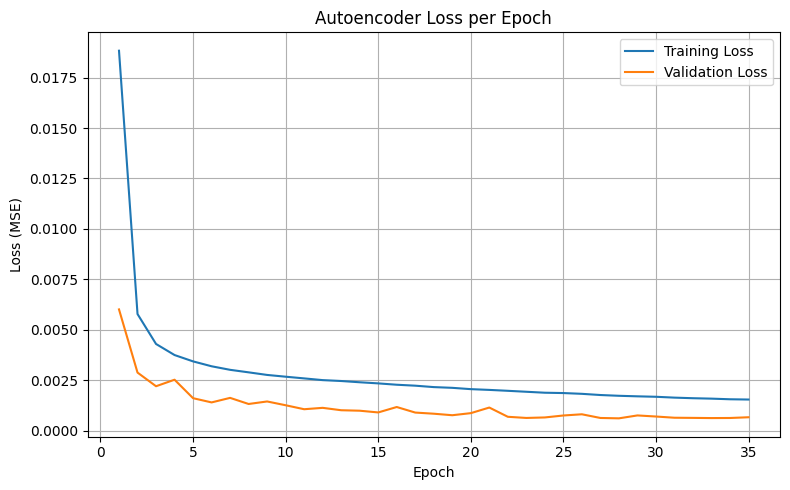

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Autoencoder Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Both the training and validation loss curves decrease together and level off, showing that the autoencoder learned to compress and reconstruct song features effectively without overfitting.


# Making Song Recommendations

With the autoencoder trained, we can now use the learned song embeddings to recommend tracks that are musically and (if available) lyrically similar.

- For any given song, we locate its embedding and compare it to all other songs using **cosine similarity**.
- Songs with the highest similarity scores are suggested as recommendations.

In [ ]:
def recommend_similar_songs(song_name, artist_name, df, embeddings, top_n=5):
    """
    song_name: str, the track name you want recommendations for
    artist_name: str, the artist name of the track
    df: pandas DataFrame, the original dataframe
    embeddings: np.ndarray, bottleneck embeddings, same order as df
    top_n: int, number of recommendations to return
    Returns: List of (track_name, artist_name, similarity, has_lyrics) tuples
    """
    from sklearn.metrics.pairwise import cosine_similarity

    matches = df[(df['track_name'] == song_name) & (df['artist_name'] == artist_name)]
    if matches.empty:
        print("Song not found!")
        return []

    idx = matches.index[0]
    similarities = cosine_similarity([embeddings[idx]], embeddings)[0]
    similarities[idx] = -1  # Exclude the song itself

    recommended_indices = [i for i in similarities.argsort()[::-1] if i != idx][:top_n]

    recommendations = []
    print(f"\nRecommendations for '{song_name}' by {artist_name}:")
    for i, rec_idx in enumerate(recommended_indices, 1):
        rec_artist = df.iloc[rec_idx]['artist_name']
        rec_title = df.iloc[rec_idx]['track_name']
        score = similarities[rec_idx]
        has_lyrics = df.iloc[rec_idx]['has_lyrics'] if 'has_lyrics' in df.columns else None
        recommendations.append((rec_title, rec_artist, score, has_lyrics))

    return recommendations

In [ ]:
embeddings = encoder.predict(X)

4053/4053 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


In [ ]:
print(df_merged[df_merged['has_lyrics'] == 0][['track_name', 'artist_name']].head(10))

                     track_name  artist_name
133                Quiere Beber     Anuel Aa
134                  Vaina Loca        Ozuna
135                    Si Se Da  Myke Towers
136                   Culpables      Karol G
137                Falling Down     Lil Peep
138                         365         Zedd
139  Waste It On Me (feat. BTS)   Steve Aoki
140                       Au DD          PNL
141  Falling Down - Bonus Track     Lil Peep
142                  Sin Pijama      Becky G


In [ ]:
r_auto = recommend_similar_songs('Quiere Beber', 'Anuel Aa', df_merged, embeddings, top_n=10)
r_auto


Recommendations for 'Quiere Beber' by Anuel Aa:


[('Ella Quiere Beber - Remix',
  'Anuel Aa',
  np.float32(0.96443117),
  np.int64(0)),
 ('Ganas Sobran', 'Bryant Myers', np.float32(0.9609531), np.int64(0)),
 ("Fallin' All In You", 'Shawn Mendes', np.float32(0.9518411), np.int64(0)),
 ('Dile la Verdad', 'The Rudeboyz', np.float32(0.9443139), np.int64(0)),
 ('PPP', 'Kevin Roldan', np.float32(0.93955064), np.int64(0)),
 ('Coméntale', 'Ozuna', np.float32(0.93952715), np.int64(0)),
 ('Imposible', 'Luis Fonsi', np.float32(0.9348809), np.int64(1)),
 ('How Can I Forget', 'MKTO', np.float32(0.9335287), np.int64(0)),
 ('Cool Again', 'Shoffy', np.float32(0.9309598), np.int64(0)),
 ('Tanta Falta', 'Bryant Myers', np.float32(0.93078303), np.int64(0))]

In [ ]:
print(df_merged[df_merged['has_lyrics'] == 1][['track_name', 'artist_name']].head(10))

                                       track_name     artist_name
0                                   thank u, next   Ariana Grande
1                                       Con Calma    Daddy Yankee
2  Taki Taki (with Selena Gomez, Ozuna & Cardi B)        DJ Snake
3                                          Sucker  Jonas Brothers
4                                         bad guy   Billie Eilish
5                                            Wow.     Post Malone
6                               MIA (feat. Drake)       Bad Bunny
7        break up with your girlfriend, i'm bored   Ariana Grande
8                                         Shallow       Lady Gaga
9          Dancing With A Stranger (with Normani)       Sam Smith


In [ ]:
recommend_similar_songs('thank u, next', 'Ariana Grande', df_merged, embeddings, top_n=10)


Recommendations for 'thank u, next' by Ariana Grande:


[('Light On', 'Maggie Rogers', np.float32(0.9783932), np.int64(0)),
 ('Kahit Ayaw Mo Na', 'This Band', np.float32(0.97460115), np.int64(0)),
 ('Sweet but Psycho', 'Ava Max', np.float32(0.9661381), np.int64(1)),
 ('Enemies', 'Lauv', np.float32(0.9648822), np.int64(0)),
 ('Natural', 'Imagine Dragons', np.float32(0.9627573), np.int64(1)),
 ('Girls Like You (feat. Cardi B)',
  'Maroon 5',
  np.float32(0.95918727),
  np.int64(1)),
 ('Born To Be Yours', 'Kygo', np.float32(0.95862454), np.int64(0)),
 ('in my head', 'Ariana Grande', np.float32(0.95735496), np.int64(0)),
 ('Two of Us', 'Louis Tomlinson', np.float32(0.9567989), np.int64(0)),
 ('Beautiful (feat. Camila Cabello)',
  'Bazzi',
  np.float32(0.95583427),
  np.int64(1))]

# Utilizing Spotify API
While I initially considered using the Spotify API to collect audio features and metadata for each track, this was not practical because Spotify restricts access to full audio features to approved developer applications and API rate limits, Instead, I left this code commented out and relied on large public Kaggle datasets that already include audio features.



In [ ]:
# !pip install spotipy
# !pip install python-dotenv
# from dotenv import load_dotenv
# import spotipy
# from spotipy.oauth2 import SpotifyOAuth
# from spotipy.oauth2 import SpotifyClientCredentials

In [ ]:
# load_dotenv("/content/drive/MyDrive/.env.txt")

# CLIENT_ID = os.getenv("SPOTIPY_CLIENT_ID")
# CLIENT_SECRET = os.getenv("SPOTIPY_CLIENT_SECRET")
# REDIRECT_URI = os.getenv("SPOTIPY_REDIRECT_URI")

In [ ]:
# sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
#     client_id=CLIENT_ID,
#     client_secret=CLIENT_SECRET,
#     redirect_uri=REDIRECT_URI,
# ))

In [ ]:
# progress_path = "/content/drive/MyDrive/spotify_metadata_progress.csv"

# # Get track IDs
# track_ids = df_big_deduped['track_id'].dropna().tolist()

# # Resume from Drive if exists
# if os.path.exists(progress_path):
#     df_meta = pd.read_csv(progress_path)
#     processed_ids = set(df_meta['track_id'].tolist())
#     print(f" Resuming: {len(processed_ids)} tracks already processed.")
# else:
#     df_meta = pd.DataFrame()
#     processed_ids = set()
#     print(" Starting fresh.")

# metadata = []
# batch_size = 100

# for i, track_id in enumerate(tqdm(track_ids), 1):
#     if track_id in processed_ids:
#         continue

#     try:
#         track = sp.track(track_id)
#         album = sp.album(track['album']['id'])
#         artist = sp.artist(track['artists'][0]['id'])

#         meta = {
#             'track_id': track_id,
#             'track_name': track.get('name'),
#             'track_popularity': track.get('popularity'),
#             'track_number': track.get('track_number'),
#             'artist_ids': '; '.join([a['id'] for a in track['artists']]),
#             'artist_names': '; '.join([a['name'] for a in track['artists']]),
#             'artist_popularity': artist.get('popularity'),
#             'artist_genres': '; '.join(artist.get('genres', [])),

#             'album_id': album['id'],
#             'album_name': album.get('name'),
#             'album_release_date': album.get('release_date'),
#             'album_type': album.get('album_type'),

#             'isrc': track.get('external_ids', {}).get('isrc'),
#             'track_spotify_url': track['external_urls'].get('spotify')
#         }

#         metadata.append(meta)
#         time.sleep(0.1)  # API rate protection

#     except Exception as e:
#         print(f" Error on track {track_id}: {e}")
#         continue  # Move to the next track in case of an error

#     # Save every batch
#     if len(metadata) >= batch_size:
#         df_new = pd.DataFrame(metadata)
#         df_meta = pd.concat([df_meta, df_new], ignore_index=True).drop_duplicates(subset='track_id')
#         df_meta.to_csv(progress_path, index=False)
#         print(f" Saved {len(df_meta)} total tracks to Drive.")
#         metadata = []

# # Final save
# if metadata:
#     df_new = pd.DataFrame(metadata)
#     df_meta = pd.concat([df_meta, df_new], ignore_index=True).drop_duplicates(subset='track_id')
#     df_meta.to_csv(progress_path, index=False)
#     print(f" Final save complete: {len(df_meta)} tracks saved.")